# BangleBeat

The following notebook walks through the process of making a machine learning model to improve BangleJS2 heart rate accuracy based on prior data. The ML model runs directly on the BangleJS2 watch and should serve as an easy to use pipeline for folks to make thier own Bangle more accurate for them. Further work may attempt to generalize this approach to yield an open source watch which actively learns how to improve its own heart rate measurements. 



## Data Capture

First, we should assess how good or bad the BangleJS2 performs when compared to other wearable devices. This includes the following devices:

- BangleJS2 Smart Watch
- Garmin Instinct 2X Smart Watch
- Polar H10 ECG Chest Strap

These are all supported to a sufficient degree by [Gadgetbridge](https://gadgetbridge.org/). However, in the initial phases of this project I found that the BangleJS2 does not sample heart rate data nearly as fast as the Garmin does. To give this model a fighting chance I wrote [loglog](https://github.com/lucspec/BangleApps/tree/master/apps/loglog) -- a BangleJS2 app to prioritize data collection over battery life. Initial testing yields a high enough data density to be more comprable with the other two sensors in this work.

## Analysis

With our sensors and collection mechanisms in place, we can start looking at some data.

In [1]:
import sys
import sqlite3
from datetime import datetime, timedelta
import os
from typing import Optional, List
from pathlib import Path
import pandas as pd

try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import stats
    import seaborn as sns
except ImportError as e:
    print(f"Error: {e}")
    print("Run: poetry install --with analysis")
    sys.exit(1)

NORMALIZED = True # Heart patterns are technically a biometric. Use normalized values if you don't want standalone graphics to identify you.


With some boilerplate out of the way, let's load up our data and see what we have.

In [2]:
#!/usr/bin/env python3
"""
Load Gadgetbridge Heart Rate Data - Bare Script
Output: gb_data DataFrame
"""

import glob
import sqlite3
import pandas as pd
from datetime import datetime

# =============================================================================
# CONFIGURATION
# =============================================================================
# These .db files can contain duplicates -- the more the merrier!
dbs = glob.glob("./data/Gadgetbridge*.db")
dbs += glob.glob("./data/gadgetbridge*/database/Gadgetbridge")
START_DATE = None  # Optional: 'YYYY-MM-DD'
END_DATE = None    # Optional: 'YYYY-MM-DD'
dataframes = []
for DB_PATH in dbs:

    # =============================================================================
    # LOAD DEVICE LIST
    # =============================================================================
    conn = sqlite3.connect(DB_PATH)

    query = """
    SELECT 
        _id as id,
        NAME as name,
        MANUFACTURER as mfg,
        IDENTIFIER as identifier,
        TYPE as type,
        TYPE_NAME as type_name,
        MODEL as model
    FROM DEVICE
    ORDER BY _id
    """

    devices = pd.read_sql_query(query, conn)

    ## Optional -- show all devices in gadgetbridge db
    #print("="*100)
    #print("GADGETBRIDGE DEVICES")
    #print("="*100)
    #print(devices.to_string(index=False))
    #print()

    # =============================================================================
    # MAP DEVICE TYPES TO TABLES
    # =============================================================================
    type_to_table = {
        'GARMIN_INSTINCT_2X_SOLAR': 'GARMIN_ACTIVITY_SAMPLE',
        'BANGLEJS': 'BANGLE_JSACTIVITY_SAMPLE',
        'POLAR': 'POLAR_H10_ACTIVITY_SAMPLE',
    }

    # =============================================================================
    # LOAD HR DATA FROM ALL DEVICES
    # =============================================================================

    for _, device in devices.iterrows():
        device_id = device['id']
        device_name = device['name']
        device_type = device['type_name']
        
        # Determine table name
        table_name = None
        
        # Try exact match first
        if device_type in type_to_table:
            table_name = type_to_table[device_type]
        # Try partial matches for variations
        elif 'GARMIN' in device_type:
            table_name = 'GARMIN_ACTIVITY_SAMPLE'
        elif 'BANGLE' in device_type:
            table_name = 'BANGLE_JSACTIVITY_SAMPLE'
        elif 'POLAR' in device_type:
            table_name = 'POLAR_H10_ACTIVITY_SAMPLE'

        if not table_name:
            ## Optional -- warn when we see devices we don't expect 
            #print(f"Warning: Unknown device type '{device_type}' for device '{device_name}', skipping")
            continue
        
        # Check if table exists
        cursor = conn.cursor()
        cursor.execute("""
            SELECT name FROM sqlite_master 
            WHERE type='table' AND name=?
        """, (table_name,))
        
        if not cursor.fetchone():
            # Optional -- warn when we can't find a table for an unknown device
            #print(f"Warning: Table '{table_name}' not found for device '{device_name}', skipping")
            continue
        
        # Build query
        query = f"""
        SELECT
            ? as device_id,
            ? as device_name,
            ? as device_type,
            TIMESTAMP,
            HEART_RATE
        FROM {table_name}
        WHERE DEVICE_ID = ? AND HEART_RATE IS NOT NULL AND HEART_RATE > 0
        """
        
        params = [device_id, device_name, device_type, device_id]
        
        if START_DATE:
            timestamp = int(datetime.strptime(START_DATE, "%Y-%m-%d").timestamp())
            query += " AND TIMESTAMP >= ?"
            params.append(timestamp)
        if END_DATE:
            timestamp = int(datetime.strptime(END_DATE, "%Y-%m-%d").timestamp())
            query += " AND TIMESTAMP <= ?"
            params.append(timestamp)
        
        query += " ORDER BY TIMESTAMP"
        
        try:
            df = pd.read_sql_query(query, conn, params=params)
            if not df.empty:
                df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit='s')
                dataframes.append(df)
                #print(f"✓ Loaded {len(df):,} measurements from {device_name} ({device_type})")
        except Exception as e:
            print(f"✗ Could not load data for {device_name}: {e}")

    conn.close()

    # =============================================================================
    # COMBINE ALL DATA
    # =============================================================================
    if dataframes:
        gb_data = pd.concat(dataframes, ignore_index=True)
        gb_data = gb_data.sort_values('datetime').reset_index(drop=True)
        print()
        print(f"- GADGETBRIDGE DATA LOADED FROM \'{DB_PATH}\'")
        print(f"    Total measurements: {len(gb_data):,}; Devices: {gb_data['device_name'].unique()}")
    else:
        print(f"Failed to extract Gadgetbridge data from {DB_PATH}")
            
gb_data.drop_duplicates()
print()
print("="*80)
print(f"TOTAL GADGETBRIDGE DATA'")
print("="*80)
print(f"Total unique measurements: {len(gb_data):,}")
print(f"Date range: {gb_data['datetime'].min()} to {gb_data['datetime'].max()}")
print()
print("By device:")
for device in gb_data['device_name'].unique():
    count = len(gb_data[gb_data['device_name'] == device])
    device_type = gb_data[gb_data['device_name'] == device]['device_type'].iloc[0]
    print(f"  - {device} ({device_type}): {count:,}")


- GADGETBRIDGE DATA LOADED FROM './data/Gadgetbridge.db'
    Total measurements: 180,604; Devices: ['Instinct 2X Solar' 'Bangle.js db9a' 'Polar H10 CC3A8829']

- GADGETBRIDGE DATA LOADED FROM './data/Gadgetbridge-px7.db'
    Total measurements: 398,745; Devices: ['Bangle.js db9a' 'Instinct 2X Solar' 'Polar H10 CC3A8829']

- GADGETBRIDGE DATA LOADED FROM './data/Gadgetbridge (1).db'
    Total measurements: 584,589; Devices: ['Bangle.js db9a' 'Instinct 2X Solar' 'Polar H10 CC3A8829']

- GADGETBRIDGE DATA LOADED FROM './data/Gadgetbridge20251120.db'
    Total measurements: 765,193; Devices: ['Bangle.js db9a' 'Instinct 2X Solar' 'Polar H10 CC3A8829']

- GADGETBRIDGE DATA LOADED FROM './data/Gadgetbridge20251121-1606.db'
    Total measurements: 960,664; Devices: ['Bangle.js db9a' 'Instinct 2X Solar' 'Polar H10 CC3A8829']

- GADGETBRIDGE DATA LOADED FROM './data/Gadgetbridge20251121-2013.db'
    Total measurements: 1,170,198; Devices: ['Bangle.js db9a' 'Instinct 2X Solar' 'Polar H10 CC3A882

In [3]:
import os
import pandas as pd
from datetime import datetime
from glob import glob

# =============================================================================
# CONFIGURATION
# =============================================================================
CSV_PATHS = glob("./data/loglog*.csv")
DEVICE_NAME = 'banglejs2-loglog'
START_DATE = None  # Optional: 'YYYY-MM-DD'
END_DATE = None    # Optional: 'YYYY-MM-DD'
loglog_list = []

# =============================================================================
# LOAD CSV WITH ENCODING HANDLING
# =============================================================================
for CSV_PATH in CSV_PATHS:
    if not os.path.exists(CSV_PATH):
        print(f"✗ Error: CSV file not found: {CSV_PATH}")
        loglog_data = pd.DataFrame()
    else:
        try:
            # Try latin-1 encoding (handles 0xb5 µ symbol)
            df = pd.read_csv(CSV_PATH, encoding='utf-8')
            
            # Clean and rename columns
            df.columns = df.columns.str.strip()
            df = df.rename(columns={
                'Epoch (ms)': 'EPOCH_MS',
                'Battery': 'battery',
                'X': 'x',
                'Y': 'y',
                'Z': 'z',
                'Total': 'total_accel',
                'BPM': 'HEART_RATE',
                'Confidence': 'confidence'
            })
            
            # Filter valid heart rate data
            df = df[df['HEART_RATE'].notna() & (df['HEART_RATE'] > 0)]
            
            # Convert timestamps
            df['TIMESTAMP'] = pd.to_numeric(df['EPOCH_MS'], errors='coerce') / 1000
            df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit='s', errors='coerce')
            df = df[df['datetime'].notna()]
            
            # Add device metadata
            df['device_name'] = DEVICE_NAME
            df['device_type'] = 'LOGLOG_CSV'
            df['device_id'] = 999
            
            # Date filtering
            if START_DATE:
                df = df[df['datetime'] >= datetime.strptime(START_DATE, "%Y-%m-%d")]
            if END_DATE:
                df = df[df['datetime'] <= datetime.strptime(END_DATE, "%Y-%m-%d")]

            
            print()
            print(f"- LOGLOG DATA LOADED FROM \'{CSV_PATH}\'")
            print(f"    Total measurements: {len(df):,}; Devices: {df['device_name'].unique()}")
            
            loglog_list.append(df)
            
            
        except Exception as e:
            print(f"✗ Error loading CSV: {e}")
            loglog_data = pd.DataFrame()

loglog_data = pd.concat(loglog_list)
loglog_data = loglog_data.drop_duplicates()


print("="*80)
print("LOGLOG DATA LOADED")
print("="*80)
print(f"Total unique measurements: {len(loglog_data):,}")
print(f"Date range: {loglog_data['datetime'].min()} to {loglog_data['datetime'].max()}")
print(f"Heart rate range: {loglog_data['HEART_RATE'].min():.0f} - {loglog_data['HEART_RATE'].max():.0f} bpm")
print(f"Heart rate mean: {loglog_data['HEART_RATE'].mean():.1f} bpm")

# Accelerometer data availability
if 'x' in loglog_data.columns:
    accel_complete = df[['x', 'y', 'z']].notna().all(axis=1).sum()
    print(f"Accelerometer samples: {accel_complete:,}")
    if accel_complete > 0:
        print(f"  X range: {loglog_data['x'].min():.0f} to {loglog_data['x'].max():.0f}")
        print(f"  Y range: {loglog_data['y'].min():.0f} to {loglog_data['y'].max():.0f}")
        print(f"  Z range: {loglog_data['z'].min():.0f} to {loglog_data['z'].max():.0f}")

# Battery info
if 'battery' in loglog_data.columns and loglog_data['battery'].notna().any():
    print(f"Battery range: {loglog_data['battery'].min():.0f}% - {loglog_data['battery'].max():.0f}%")

# Confidence info
if 'confidence' in loglog_data.columns and loglog_data['confidence'].notna().any():
    # Bin confidence into low/medium/high
    LOW = 40
    MED = 80
    conf_values = loglog_data['confidence']
    count = len(conf_values)
    low    = ((conf_values >= 0)   & (conf_values < LOW)).sum()
    medium = ((conf_values >= LOW) & (conf_values < MED)).sum()
    high   = (conf_values >= MED).sum()
    print(f"Confidence: Low (0-{LOW}): {low/count*100:.1f}, Medium ({LOW}-{MED}): {medium/count*100:.1f}, High ({MED}+): {high/count*100:.1f}")



- LOGLOG DATA LOADED FROM './data/loglog.csv'
    Total measurements: 17,752; Devices: ['banglejs2-loglog']

- LOGLOG DATA LOADED FROM './data/loglog (1).csv'
    Total measurements: 17,752; Devices: ['banglejs2-loglog']

- LOGLOG DATA LOADED FROM './data/loglog.20251121-1423.csv'
    Total measurements: 1,853; Devices: ['banglejs2-loglog']

- LOGLOG DATA LOADED FROM './data/loglog.0 (1).csv'
    Total measurements: 49; Devices: ['banglejs2-loglog']

- LOGLOG DATA LOADED FROM './data/loglog.0 (2).csv'
    Total measurements: 11; Devices: ['banglejs2-loglog']

- LOGLOG DATA LOADED FROM './data/loglog.0 (3).csv'
    Total measurements: 90; Devices: ['banglejs2-loglog']

- LOGLOG DATA LOADED FROM './data/loglog.0.csv'
    Total measurements: 14; Devices: ['banglejs2-loglog']
LOGLOG DATA LOADED
Total unique measurements: 19,758
Date range: 2025-11-17 06:42:05.175050020 to 2025-11-21 22:52:43.852861166
Heart rate range: 4 - 110 bpm
Heart rate mean: 63.4 bpm
Accelerometer samples: 0
Battery

In [4]:
#!/usr/bin/env python3
"""
Combine and Normalize HR Data - Bare Script
Input: gb_data, loglog_data (or any DataFrames with HR data)
Output: hr_data (combined and normalized)
"""

import pandas as pd

# =============================================================================
# CONFIGURATION
# =============================================================================
DATE_FMT = '%Y-%m-%d'

# =============================================================================
# COMBINE DATA FROM MULTIPLE SOURCES
# =============================================================================
print(f'{"="*80}\nCOMBINING DATA SOURCES\n{"="*80}')

# List of dataframes to combine (add or remove as needed)
dfs_to_combine = []

# Add Gadgetbridge data if it exists and is not empty
if 'gb_data' in locals() and not gb_data.empty:
    dfs_to_combine.append(gb_data)
    print(f"✓ Including Gadgetbridge data: {len(gb_data):,} measurements")

# Add Loglog data if it exists and is not empty  
if 'loglog_data' in locals() and not loglog_data.empty:
    dfs_to_combine.append(loglog_data)
    print(f"✓ Including Loglog data: {len(loglog_data):,} measurements")

# Combine all dataframes
if dfs_to_combine:
    hr_data = pd.concat(dfs_to_combine, ignore_index=True)
    hr_data = hr_data.sort_values('datetime').reset_index(drop=True)
    
    print(f"\nTotal combined measurements: {len(hr_data):,}")
    print(f"Date range: {hr_data['datetime'].min().strftime(DATE_FMT)} to {hr_data['datetime'].max().strftime(DATE_FMT)}")
    
else:
    print("✗ No data to combine!")
    hr_data = pd.DataFrame()


COMBINING DATA SOURCES
✓ Including Gadgetbridge data: 1,569,054 measurements
✓ Including Loglog data: 19,758 measurements

Total combined measurements: 1,588,812
Date range: 1970-01-01 to 2025-11-22


In [5]:
print("\nDevices in combined data:")
for device in hr_data['device_name'].unique():
    device_data = hr_data[hr_data['device_name'] == device]
    count = len(device_data)
    device_type = device_data['device_type'].iloc[0]
    date_range = device_data['datetime']
    hr_range = device_data['HEART_RATE']
    
    print(f"\n  {device} ({device_type}):")
    print(f"    Measurements: {count:,}")
    print(f"    Date range: {date_range.min().strftime('%Y-%m-%d %H:%M')} to {date_range.max().strftime('%Y-%m-%d %H:%M')}")
    print(f"    HR range: {hr_range.min():.0f} - {hr_range.max():.0f} bpm (mean: {hr_range.mean():.1f})")
    
    # Show accelerometer data if available
    if 'x' in device_data.columns:
        accel_complete = device_data[['x', 'y', 'z']].notna().all(axis=1).sum()
        if accel_complete > 0:
            print(f"    Accelerometer: {accel_complete:,} samples")


Devices in combined data:

  Bangle.js db9a (BANGLEJS):
    Measurements: 24,504
    Date range: 1970-01-01 00:00 to 2025-11-22 02:20
    HR range: 49 - 184 bpm (mean: 80.4)

  Instinct 2X Solar (GARMIN_INSTINCT_2X_SOLAR):
    Measurements: 1,300,649
    Date range: 2025-06-08 14:12 to 2025-11-14 05:59
    HR range: 38 - 176 bpm (mean: 76.3)

  Polar H10 CC3A8829 (POLARH10):
    Measurements: 243,901
    Date range: 2025-11-09 18:26 to 2025-11-22 03:12
    HR range: 58 - 174 bpm (mean: 80.4)

  banglejs2-loglog (LOGLOG_CSV):
    Measurements: 19,758
    Date range: 2025-11-17 06:42 to 2025-11-21 22:52
    HR range: 4 - 110 bpm (mean: 63.4)


In [6]:
import random
# =============================================================================
# CONFIGURATION
# =============================================================================
# Heart rate range for normalization, semi-anonymized -- HR is a biometric
MIN_HR = 0 # Minimum heart rate for normalization
#MIN_HR = hr_data['HEART_RATE'].min() # force 0-1 to actual measurement range
MAX_HR = hr_data['HEART_RATE'].max()  

# =============================================================================
# NORMALIZE HEART RATE DATA IN DEDICATED COLUMN
# =============================================================================
if not hr_data.empty and 'HEART_RATE' in hr_data.columns:
    print()
    print("="*80)
    #print(f"NORMALIZING HEART RATE ({MIN_HR}-{MAX_HR} bpm → 0-1 scale)")
    print(f"NORMALIZING HEART RATE → 0-1 scale")
    print("="*80)
    
    # Normalize to 0-1 scale
    hr_data['HR_NORMALIZED'] = (hr_data['HEART_RATE'] - MIN_HR) / (MAX_HR - MIN_HR)
    
    # Clip values to 0-1 range (in case of values outside min/max)
    #hr_data['HR_NORMALIZED'] = hr_data['HR_NORMALIZED'].clip(0, 1)
    
    print(f"✓ Added HR_NORMALIZED column")
    print(f"  Range: {hr_data['HR_NORMALIZED'].min():.3f} to {hr_data['HR_NORMALIZED'].max():.3f}")
    print(f"  Mean: {hr_data['HR_NORMALIZED'].mean():.3f}")
    
    # Show any clipped values
    clipped_low = (hr_data['HEART_RATE'] < MIN_HR).sum()
    clipped_high = (hr_data['HEART_RATE'] > MAX_HR).sum()
    if clipped_low > 0:
        print(f"  ⚠ Clipped {clipped_low} values below {MIN_HR} bpm to 0.0")
    if clipped_high > 0:
        print(f"  ⚠ Clipped {clipped_high} values above {MAX_HR} bpm to 1.0")



NORMALIZING HEART RATE → 0-1 scale
✓ Added HR_NORMALIZED column
  Range: 0.022 to 1.000
  Mean: 0.418


First, a quick look at what the data looks like. Raw distribution gives a good feel for how "big" of a data set we have for each device. The normalized density shows how (dis)similar our sets are.

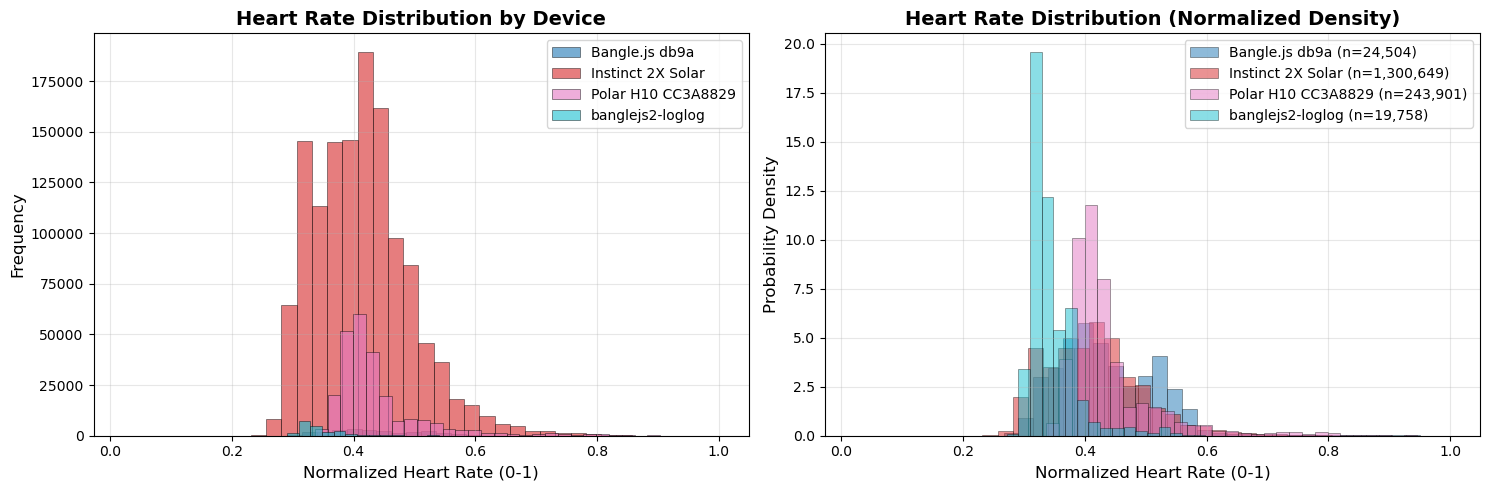

HISTOGRAM STATISTICS

Bangle.js db9a:
  Count: 24,504
  Mean: 0.44
  Std Dev: 0.08
  Range: 0.27 - 1.00

Instinct 2X Solar:
  Count: 1,300,649
  Mean: 0.41
  Std Dev: 0.08
  Range: 0.21 - 0.96

Polar H10 CC3A8829:
  Count: 243,901
  Mean: 0.44
  Std Dev: 0.07
  Range: 0.32 - 0.95

banglejs2-loglog:
  Count: 19,758
  Mean: 0.34
  Std Dev: 0.04
  Range: 0.02 - 0.60


In [7]:
#!/usr/bin/env python3
"""
Heart Rate Distribution Histograms
Input: hr_data DataFrame
"""

import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
BINS = 30
FIGSIZE = (15, 5)

# =============================================================================
# PLOT HISTOGRAMS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found. Run combine_and_normalize.py first.")
else:
    fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)
    
    devices = sorted(hr_data['device_name'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(devices)))
    
    # Select column
    hr_column = 'HR_NORMALIZED' if NORMALIZED and 'HR_NORMALIZED' in hr_data.columns else 'HEART_RATE'
    xlabel = 'Normalized Heart Rate (0-1)' if NORMALIZED else 'Heart Rate (bpm)'
    
    # Left: Individual histograms (stacked)
    for device, color in zip(devices, colors):
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        axes[0].hist(device_data, bins=BINS, alpha=0.6, label=device, 
                    color=color, edgecolor='black', linewidth=0.5)
    
    axes[0].set_title('Heart Rate Distribution by Device', fontsize=14, fontweight='bold')
    axes[0].set_xlabel(xlabel, fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Right: Density plots (normalized for comparison)
    for device, color in zip(devices, colors):
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        n_samples = len(device_data)
        axes[1].hist(device_data, bins=BINS, alpha=0.5, 
                    label=f'{device} (n={n_samples:,})', 
                    color=color, edgecolor='black', linewidth=0.5,
                    density=True)
    
    axes[1].set_title('Heart Rate Distribution (Normalized Density)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel(xlabel, fontsize=12)
    axes[1].set_ylabel('Probability Density', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("="*80)
    print("HISTOGRAM STATISTICS")
    print("="*80)
    for device in devices:
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        print(f"\n{device}:")
        print(f"  Count: {len(device_data):,}")
        print(f"  Mean: {device_data.mean():.2f}")
        print(f"  Std Dev: {device_data.std():.2f}")
        print(f"  Range: {device_data.min():.2f} - {device_data.max():.2f}")

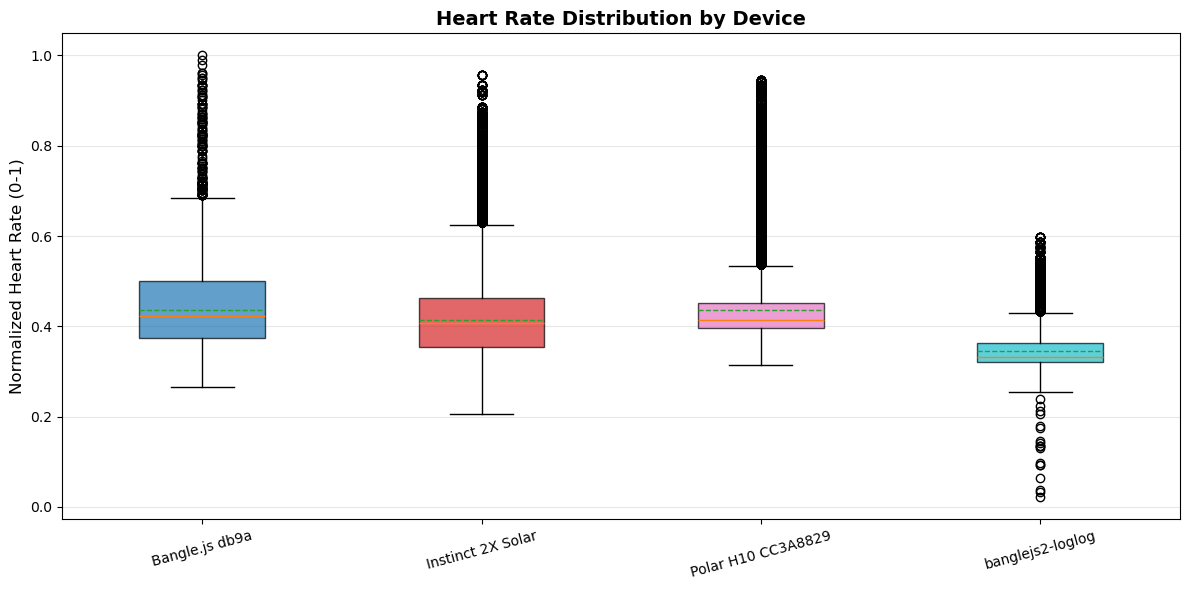

BOX PLOT STATISTICS

Bangle.js db9a:
  Min: 0.27
  Q1 (25%): 0.38
  Median: 0.42
  Q3 (75%): 0.50
  Max: 1.00
  IQR: 0.12
  Outliers: 154 (0.6%)

Instinct 2X Solar:
  Min: 0.21
  Q1 (25%): 0.35
  Median: 0.41
  Q3 (75%): 0.46
  Max: 0.96
  IQR: 0.11
  Outliers: 21036 (1.6%)

Polar H10 CC3A8829:
  Min: 0.32
  Q1 (25%): 0.40
  Median: 0.41
  Q3 (75%): 0.45
  Max: 0.95
  IQR: 0.05
  Outliers: 20969 (8.6%)

banglejs2-loglog:
  Min: 0.02
  Q1 (25%): 0.32
  Median: 0.33
  Q3 (75%): 0.36
  Max: 0.60
  IQR: 0.04
  Outliers: 881 (4.5%)


In [8]:
#!/usr/bin/env python3
"""
Heart Rate Box Plots
Input: hr_data DataFrame
"""

import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
FIGSIZE = (12, 6)

# =============================================================================
# PLOT BOX PLOTS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found. Run combine_and_normalize.py first.")
else:
    devices = sorted(hr_data['device_name'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(devices)))
    
    # Select column
    hr_column = 'HR_NORMALIZED' if NORMALIZED and 'HR_NORMALIZED' in hr_data.columns else 'HEART_RATE'
    ylabel = 'Normalized Heart Rate (0-1)' if NORMALIZED else 'Heart Rate (bpm)'
    
    # Prepare data for box plot
    data_for_box = [hr_data[hr_data['device_name'] == d][hr_column].values for d in devices]
    
    fig, ax = plt.subplots(figsize=FIGSIZE)
    
    bp = ax.boxplot(data_for_box, tick_labels=devices, patch_artist=True,
                   showmeans=True, meanline=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Style the plot
    ax.set_title('Heart Rate Distribution by Device', fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("="*80)
    print("BOX PLOT STATISTICS")
    print("="*80)
    for device in devices:
        device_data = hr_data[hr_data['device_name'] == device][hr_column]
        q1, q2, q3 = device_data.quantile([0.25, 0.5, 0.75])
        iqr = q3 - q1
        lower_whisker = max(device_data.min(), q1 - 1.5 * iqr)
        upper_whisker = min(device_data.max(), q3 + 1.5 * iqr)
        outliers = ((device_data < lower_whisker) | (device_data > upper_whisker)).sum()
        
        print(f"\n{device}:")
        print(f"  Min: {device_data.min():.2f}")
        print(f"  Q1 (25%): {q1:.2f}")
        print(f"  Median: {q2:.2f}")
        print(f"  Q3 (75%): {q3:.2f}")
        print(f"  Max: {device_data.max():.2f}")
        print(f"  IQR: {iqr:.2f}")
        print(f"  Outliers: {outliers} ({outliers/len(device_data)*100:.1f}%)")

CORRELATION ANALYSIS (vs Polar H10 CC3A8829)

Bangle.js db9a:
  Paired samples: 275
  Correlation (R): 0.396
  R²: 0.157
  MAE: 0.05 bpm
  RMSE: 0.07 bpm
  Mean difference: 0.02 bpm

Instinct 2X Solar:
  Paired samples: 3,704
  Correlation (R): 0.722
  R²: 0.522
  MAE: 0.03 bpm
  RMSE: 0.04 bpm
  Mean difference: -0.01 bpm

banglejs2-loglog:
  Paired samples: 1,957
  Correlation (R): 0.097
  R²: 0.009
  MAE: 0.04 bpm
  RMSE: 0.07 bpm
  Mean difference: 0.02 bpm


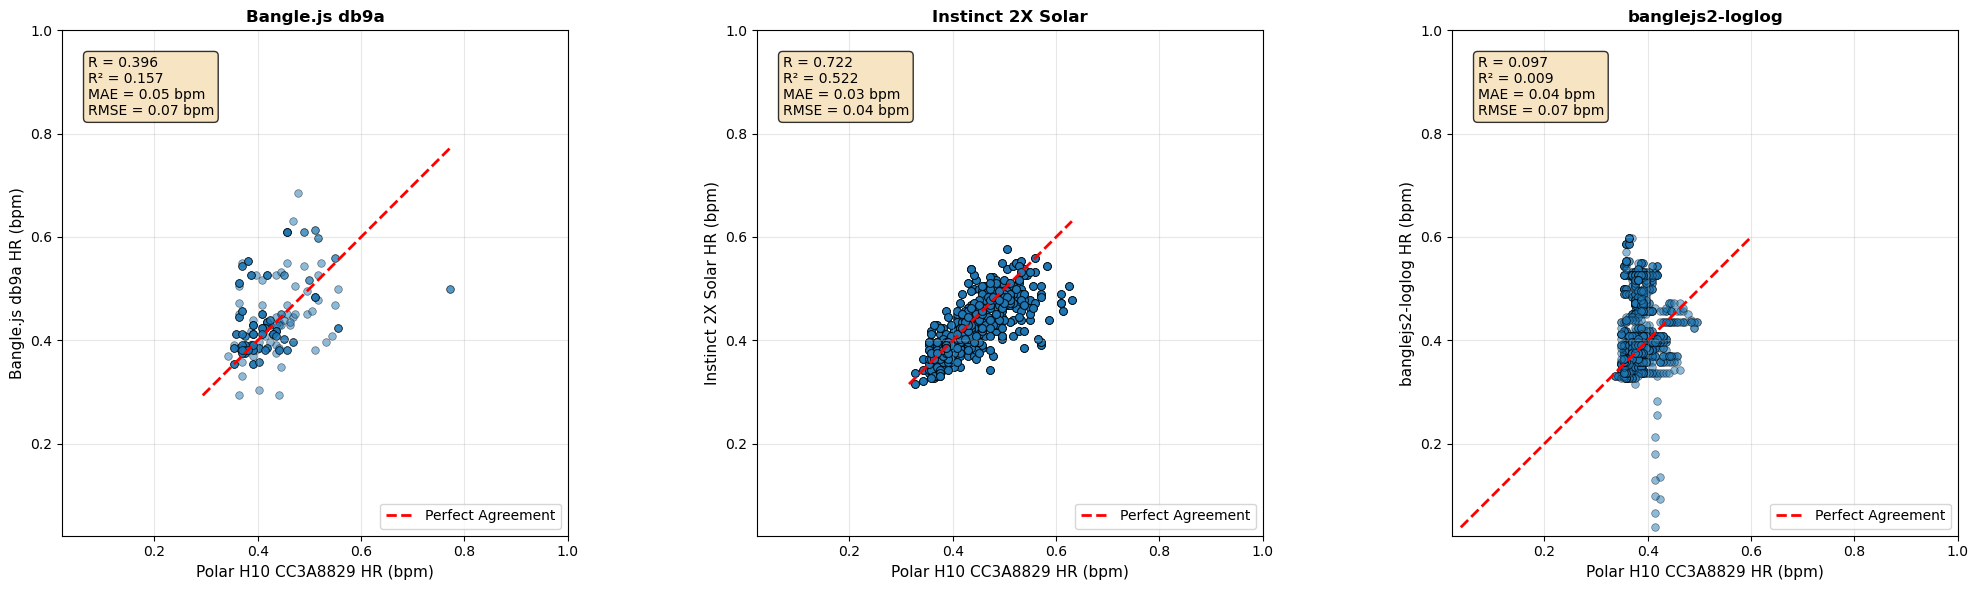

In [9]:
#!/usr/bin/env python3
"""
Device HR Correlation Scatter Plots
Shows how well each device correlates with reference device
Input: hr_data DataFrame
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# =============================================================================
# CONFIGURATION
# =============================================================================
REFERENCE_DEVICE = 'Polar H10 CC3A8829'  # Reference device (gold standard)
TOLERANCE_SECONDS = 60  # Max time difference for matching measurements
FIGSIZE_PER_DEVICE = 7
PLOT_RANGE = [hr_data['HR_NORMALIZED'].min(),hr_data['HR_NORMALIZED'].max()]

# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================
if 'hr_data' not in locals() or hr_data.empty:
    print("Error: hr_data not found. Run combine_and_normalize.py first.")
else:
    # Try to find reference device
    polar_data = hr_data[hr_data['device_name'] == REFERENCE_DEVICE]
    
    if polar_data.empty:
        polar_matches = hr_data[hr_data['device_name'].str.contains('Polar', case=False, na=False)]
        if not polar_matches.empty:
            REFERENCE_DEVICE = polar_matches['device_name'].iloc[0]
            polar_data = hr_data[hr_data['device_name'] == REFERENCE_DEVICE]
            print(f"Using reference device: {REFERENCE_DEVICE}")
    
    if polar_data.empty:
        print(f"Error: Reference device not found in data")
        print(f"Available devices: {list(hr_data['device_name'].unique())}")
    else:
        polar_data = polar_data[['datetime', 'HR_NORMALIZED']].copy()
        polar_data.columns = ['datetime', 'polar_hr']
        
        other_devices = [d for d in hr_data['device_name'].unique() if d != REFERENCE_DEVICE]
        
        if not other_devices:
            print("Error: Need at least one other device for comparison")
        else:
            n_devices = len(other_devices)
            fig, axes = plt.subplots(1, n_devices, figsize=(FIGSIZE_PER_DEVICE*n_devices, 6))
            
            if n_devices == 1:
                axes = [axes]
            
            print("="*80)
            print(f"CORRELATION ANALYSIS (vs {REFERENCE_DEVICE})")
            print("="*80)
            
            for idx, device in enumerate(other_devices):
                device_data = hr_data[hr_data['device_name'] == device][['datetime', 'HR_NORMALIZED']].copy()
                device_data.columns = ['datetime', 'device_hr']
                
                # Merge on nearest timestamps
                merged = pd.merge_asof(
                    device_data.sort_values('datetime'),
                    polar_data.sort_values('datetime'),
                    on='datetime',
                    direction='nearest',
                    tolerance=pd.Timedelta(f'{TOLERANCE_SECONDS}s')
                ).dropna()
                
                if not merged.empty:
                    axes[idx].scatter(merged['polar_hr'], merged['device_hr'], 
                                     alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
                    
                    # Plot perfect agreement line
                    min_val = min(merged['polar_hr'].min(), merged['device_hr'].min())
                    max_val = max(merged['polar_hr'].max(), merged['device_hr'].max())
                    axes[idx].plot([min_val, max_val], [min_val, max_val], 
                                  'r--', linewidth=2, label='Perfect Agreement')
                    
                    # Calculate statistics
                    correlation = merged['polar_hr'].corr(merged['device_hr'])
                    mae = np.abs(merged['device_hr'] - merged['polar_hr']).mean()
                    rmse = np.sqrt(((merged['device_hr'] - merged['polar_hr']) ** 2).mean())
                    
                    # Display stats on plot
                    stats_text = f'R = {correlation:.3f}\nR² = {correlation**2:.3f}\nMAE = {mae:.2f} bpm\nRMSE = {rmse:.2f} bpm'
                    axes[idx].text(0.05, 0.95, stats_text,
                                  transform=axes[idx].transAxes, 
                                  verticalalignment='top',
                                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                                  fontsize=10)
                    
                    axes[idx].set_xlabel(f'{REFERENCE_DEVICE} HR (bpm)', fontsize=11)
                    axes[idx].set_ylabel(f'{device} HR (bpm)', fontsize=11)
                    axes[idx].set_xlim(PLOT_RANGE)
                    axes[idx].set_ylim(PLOT_RANGE)
                    axes[idx].set_title(f'{device}', fontsize=12, fontweight='bold')
                    axes[idx].legend(loc='lower right')
                    axes[idx].grid(True, alpha=0.3)
                    axes[idx].set_aspect('equal', adjustable='box')
                    
                    # Print statistics
                    print(f"\n{device}:")
                    print(f"  Paired samples: {len(merged):,}")
                    print(f"  Correlation (R): {correlation:.3f}")
                    print(f"  R²: {correlation**2:.3f}")
                    print(f"  MAE: {mae:.2f} bpm")
                    print(f"  RMSE: {rmse:.2f} bpm")
                    print(f"  Mean difference: {(merged['device_hr'] - merged['polar_hr']).mean():.2f} bpm")
                else:
                    axes[idx].text(0.5, 0.5, f'No overlapping data\nwith {REFERENCE_DEVICE}',
                                  ha='center', va='center', transform=axes[idx].transAxes,
                                  fontsize=12)
                    axes[idx].set_title(f'{device}', fontsize=12, fontweight='bold')
                    print(f"\n{device}: No overlapping data within {TOLERANCE_SECONDS}s")
            
            plt.tight_layout()
            plt.show()

In [11]:
# %% [markdown]
# # HRM Calibration Model
# Train ML model to improve Bangle.js 2 HRM using Garmin/Polar reference data

# %% Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

sns.set_style('whitegrid')


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# ## Step 1: Time Alignment
# Align Bangle.js readings with reference device readings

# %%
def align_hrm_data(bangle_df, reference_df, time_col='timestamp', 
                   bangle_hr_col='heart_rate', reference_hr_col='heart_rate',
                   max_time_diff='5s'):
    """
    Align Bangle.js readings with reference device (Garmin/Polar) readings
    Uses nearest-neighbor matching within max_time_diff window
    """
    bangle_df = bangle_df.copy()
    reference_df = reference_df.copy()
    bangle_df[time_col] = pd.to_datetime(bangle_df[time_col])
    reference_df[time_col] = pd.to_datetime(reference_df[time_col])
    
    bangle_df = bangle_df.sort_values(time_col)
    reference_df = reference_df.sort_values(time_col)
    
    aligned = pd.merge_asof(
        bangle_df, 
        reference_df,
        on=time_col,
        direction='nearest',
        tolerance=pd.Timedelta(max_time_diff),
        suffixes=('_bangle', '_ref')
    )
    
    aligned = aligned.dropna(subset=[f'{bangle_hr_col}_bangle', f'{reference_hr_col}_ref'])
    
    print(f"Aligned {len(aligned)} data points")
    print(f"Time range: {aligned[time_col].min()} to {aligned[time_col].max()}")
    
    return aligned


In [ ]:
# %% Align your data
# Update column names as needed for your dataframes
aligned_data = align_hrm_data(
    gb_data,  # Your Bangle.js data from Gadgetbridge
    garmin_data,  # Your Garmin reference data
    time_col='timestamp',
    bangle_hr_col='heart_rate',
    reference_hr_col='heart_rate',
    max_time_diff='5s'
)

aligned_data.head()

# %% [markdown]
# ## Step 2: Feature Engineering

# %%
def create_features(df, hr_col_bangle='heart_rate_bangle'):
    """Create features for the ML model"""
    df = df.copy()
    
    # Basic feature: the raw Bangle HRM reading
    df['hrm_raw'] = df[hr_col_bangle]
    
    # Rate of change features
    df['hrm_diff_1'] = df['hrm_raw'].diff(1)
    df['hrm_diff_5'] = df['hrm_raw'].diff(5)
    
    # Rolling statistics
    df['hrm_rolling_mean_5'] = df['hrm_raw'].rolling(window=5, min_periods=1).mean()
    df['hrm_rolling_std_5'] = df['hrm_raw'].rolling(window=5, min_periods=1).std()
    
    # Relative position (useful for systematic bias)
    df['hrm_percentile'] = df['hrm_raw'] / df['hrm_raw'].max()
    
    # Time-based features
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Fill any NaN values
    df = df.fillna(method='bfill').fillna(method='ffill')
    
    return df

# %% Create features
aligned_data = create_features(aligned_data)
aligned_data.head()

# %% [markdown]
# ## Step 3: Prepare Training Data

# %%
feature_cols = [
    'hrm_raw', 'hrm_diff_1', 'hrm_diff_5',
    'hrm_rolling_mean_5', 'hrm_rolling_std_5',
    'hrm_percentile', 'hour_sin', 'hour_cos'
]

X = aligned_data[feature_cols].copy()
y = aligned_data['heart_rate_ref'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used: {feature_cols}")

# %% [markdown]
# ## Step 4: Train & Evaluate Models

# %%
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# %% Train Ridge Regression
print("Training Ridge Regression...")
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge - MAE: {mae_ridge:.2f} bpm, RMSE: {rmse_ridge:.2f} bpm, R²: {r2_ridge:.3f}")

# %% Train Random Forest
print("Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf:.2f} bpm, RMSE: {rmse_rf:.2f} bpm, R²: {r2_rf:.3f}")

# %% Train Gradient Boosting
print("Training Gradient Boosting...")
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - MAE: {mae_gb:.2f} bpm, RMSE: {rmse_gb:.2f} bpm, R²: {r2_gb:.3f}")

# %% [markdown]
# ## Step 5: Compare Models

# %%
results_df = pd.DataFrame({
    'Model': ['Ridge', 'Random Forest', 'Gradient Boosting'],
    'MAE (bpm)': [mae_ridge, mae_rf, mae_gb],
    'RMSE (bpm)': [rmse_ridge, rmse_rf, rmse_gb],
    'R² Score': [r2_ridge, r2_rf, r2_gb]
})

print("\nModel Comparison:")
print("="*60)
print(results_df.to_string(index=False))

# %% [markdown]
# ## Step 6: Visualize Results

# %% Plot predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = [
    ('Ridge', y_pred_ridge, mae_ridge),
    ('Random Forest', y_pred_rf, mae_rf),
    ('Gradient Boosting', y_pred_gb, mae_gb)
]

for idx, (name, y_pred, mae) in enumerate(models):
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20)
    axes[idx].plot([y_test.min(), y_test.max()], 
                   [y_test.min(), y_test.max()], 
                   'r--', lw=2)
    axes[idx].set_xlabel('Actual HR (bpm)', fontsize=12)
    axes[idx].set_ylabel('Predicted HR (bpm)', fontsize=12)
    axes[idx].set_title(f'{name}\nMAE: {mae:.2f} bpm', fontsize=14)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% Plot error distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, y_pred, mae) in enumerate(models):
    errors = y_pred - y_test
    axes[idx].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].axvline(0, color='r', linestyle='--', lw=2)
    axes[idx].set_xlabel('Prediction Error (bpm)', fontsize=12)
    axes[idx].set_ylabel('Frequency', fontsize=12)
    axes[idx].set_title(f'{name}\nMean Error: {errors.mean():.2f} bpm', fontsize=14)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## Step 7: Analyze Error by HR Range

# %% Choose best model (lowest MAE)
best_model_idx = np.argmin([mae_ridge, mae_rf, mae_gb])
best_model_name = ['Ridge', 'Random Forest', 'Gradient Boosting'][best_model_idx]
best_y_pred = [y_pred_ridge, y_pred_rf, y_pred_gb][best_model_idx]

print(f"Best model: {best_model_name}")

# %%
df_error = pd.DataFrame({
    'actual': y_test,
    'predicted': best_y_pred,
    'error': best_y_pred - y_test,
    'abs_error': np.abs(best_y_pred - y_test)
})

# Bin by HR range
bins = [0, 60, 100, 140, 180, 300]
labels = ['Resting\n(<60)', 'Light\n(60-100)', 'Moderate\n(100-140)', 
          'Vigorous\n(140-180)', 'Maximum\n(>180)']
df_error['hr_range'] = pd.cut(df_error['actual'], bins=bins, labels=labels)

# Calculate stats by range
range_stats = df_error.groupby('hr_range')['abs_error'].agg(['mean', 'std', 'count'])

print("\nError Analysis by HR Range:")
print("="*60)
print(range_stats)

# %% Plot error by HR range
plt.figure(figsize=(10, 6))
df_error.boxplot(column='abs_error', by='hr_range', ax=plt.gca())
plt.xlabel('Heart Rate Range', fontsize=12)
plt.ylabel('Absolute Error (bpm)', fontsize=12)
plt.title(f'HRM Calibration Error by Heart Rate Range ({best_model_name})', fontsize=14)
plt.suptitle('')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## Step 8: Feature Importance (for tree-based models)

# %% Feature importance for Random Forest
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    best_model = rf if best_model_name == 'Random Forest' else gb
    
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Feature Importance ({best_model_name})', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nFeature Importance:")
    print(importance_df.to_string(index=False))

# %% [markdown]
# ## Step 9: Save Best Model

# %%
# Choose which model to save
if best_model_name == 'Ridge':
    model_to_save = ridge
    scaler_to_save = scaler
elif best_model_name == 'Random Forest':
    model_to_save = rf
    scaler_to_save = None
else:  # Gradient Boosting
    model_to_save = gb
    scaler_to_save = None

model_package = {
    'model': model_to_save,
    'scaler': scaler_to_save,
    'feature_cols': feature_cols,
    'model_name': best_model_name,
    'mae': [mae_ridge, mae_rf, mae_gb][best_model_idx],
    'rmse': [rmse_ridge, rmse_rf, rmse_gb][best_model_idx],
    'r2': [r2_ridge, r2_rf, r2_gb][best_model_idx]
}

output_path = 'hrm_calibration_model.pkl'
joblib.dump(model_package, output_path)
print(f"\nModel saved to: {output_path}")
print(f"Model: {best_model_name}")
print(f"MAE: {model_package['mae']:.2f} bpm")

# %% [markdown]
# ## Step 10: Using the Model

# %%
def calibrate_hrm(bangle_data, model_path='hrm_calibration_model.pkl'):
    """
    Apply calibration to new Bangle.js data
    
    Parameters:
    -----------
    bangle_data : DataFrame
        Bangle.js data with at least 'timestamp' and 'heart_rate' columns
    model_path : str
        Path to saved model file
        
    Returns:
    --------
    calibrated_hr : array
        Calibrated heart rate values
    """
    # Load model
    model_package = joblib.load(model_path)
    
    # Prepare features
    df_features = create_features(bangle_data.copy(), hr_col_bangle='heart_rate')
    X_new = df_features[model_package['feature_cols']]
    
    # Predict
    if model_package['scaler'] is not None:
        X_new_scaled = model_package['scaler'].transform(X_new)
        predictions = model_package['model'].predict(X_new_scaled)
    else:
        predictions = model_package['model'].predict(X_new)
    
    return predictions

# Example usage:
# calibrated_hr = calibrate_hrm(gb_data)
# gb_data['heart_rate_calibrated'] = calibrated_hr